In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn
import sklearn


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Dropout, LSTM, Input,SpatialDropout1D, GlobalMaxPool1D, MaxPooling1D, Flatten
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn import model_selection
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, precision_score, accuracy_score, recall_score, f1_score
from tensorflow.keras.optimizers import Adam

In [3]:
# 5. Membaca file CSV ke dalam DataFrame
import pandas as pd
df = pd.read_csv('dataset_50k.csv')
df.head()

Unnamed: 0  Label                                         detokenize
0           0      1  aku luka diri aku jalan hidup sulit orang tua ...
1           1      0   buang pikir negatif laku gelisah milik putus asa
2           2      1  jujur aku takut mati aku orang aku sulit paham...
3           3      0              saya mes pasang sepatu jam saya harap
4           4      1  capek hati banget aku allah aku kayak mata ora...

In [5]:
df = df.dropna()
df

Unnamed: 0  Label                                         detokenize
0               0      1  aku luka diri aku jalan hidup sulit orang tua ...
1               1      0   buang pikir negatif laku gelisah milik putus asa
2               2      1  jujur aku takut mati aku orang aku sulit paham...
3               3      0              saya mes pasang sepatu jam saya harap
4               4      1  capek hati banget aku allah aku kayak mata ora...
...           ...    ...                                                ...
50518       50518      0  curi rampok liar begal rakyat senantiasa resah...
50519       50519      0                      saya bicara saya buat tertawa
50520       50520      1  sakit sakit guna sakit bahagia sakit bohong or...
50521       50521      1                              lantai lantai gelisah
50522       50522      1  aku tulis catat kemarin kata tunang aku laku b...

[50523 rows x 3 columns]

In [7]:
df['label'] = df['Label'].apply(lambda x: 0 if x == 0 else 1)
df.head()

Unnamed: 0  Label                                         detokenize  label
0           0      1  aku luka diri aku jalan hidup sulit orang tua ...      1
1           1      0   buang pikir negatif laku gelisah milik putus asa      0
2           2      1  jujur aku takut mati aku orang aku sulit paham...      1
3           3      0              saya mes pasang sepatu jam saya harap      0
4           4      1  capek hati banget aku allah aku kayak mata ora...      1

<BarContainer object of 2 artists>

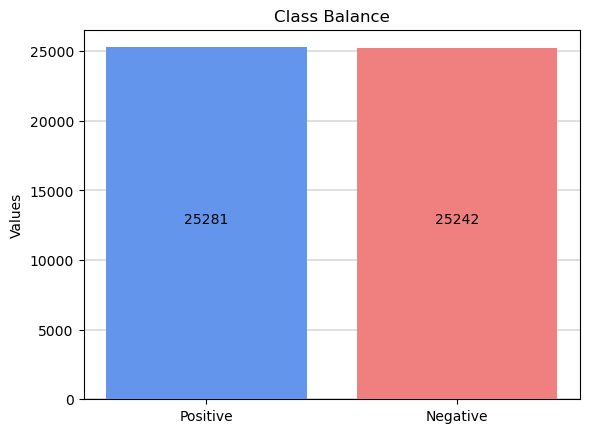

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i]//2, y[i], ha = 'center',zorder=4)

# Count the values in the 'Label' column
count = df['Label'].value_counts()
x = ["Positive", "Negative"]  # Custom labels for class balance plot
y = [count[1], count[0]]
addlabels(x,y)
plt.ylabel("Values")
plt.title('Class Balance')
plt.grid(color='dimgray', linewidth=0.3, axis='y',zorder=0)
plt.bar(x,y, color= ['cornflowerblue', 'lightcoral'], zorder=3)

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Vektorisasi teks menggunakan TF-IDF unigram(1,1)
vectorizer = TfidfVectorizer(min_df=10, ngram_range=(1,1), max_df=0.7, max_features=10000)

# Menggunakan fit_transform untuk mengubah dokumen menjadi fitur
vector = vectorizer.fit_transform(df['detokenize']).toarray()
tf_idf_len = len(vectorizer.vocabulary_)

In [13]:
#Split data 80% data train and 20% data test
x_unigram = pd.DataFrame(vector)
label = df["Label"]
x_train, x_test, y_train, y_test =  model_selection.train_test_split(x_unigram,label, test_size = 0.1)
print(x_train.shape,y_train.shape)
print(x_test.shape,y_test.shape)

(45470, 3445) (45470,)
(5053, 3445) (5053,)


In [15]:
y_train

5015     0
18806    0
19079    0
38964    0
24700    0
        ..
7526     1
4344     0
35333    1
8466     1
30040    1
Name: Label, Length: 45470, dtype: int64

In [17]:
x_train = np.array(x_train).reshape(-1, 1, x_train.shape[1])
x_test = np.array(x_test).reshape(-1, 1, x_test.shape[1])

In [19]:
x_train

array([[[0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.]]])

In [21]:
x_train.shape

(45470, 1, 3445)

In [23]:
import matplotlib.pyplot as plt

def make_plot(history, train, validation, title):
    graph = plt.plot(history.history[train], lw=2.0)
    graph = plt.plot(history.history[validation], lw=2.0)
    graph = plt.title(title)
    graph = plt.legend(['training', 'validasi'])
    graph = plt.show()

    return graph

In [25]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Membuat model hybrid lstm-cnn
def hybrid_lstm_cnn(x_train, y_train, x_test, y_test):


    model = Sequential()
    model.add(Input(shape=(1,x_train.shape[2])))
    model.add(SpatialDropout1D(0.2))
    model.add(LSTM(128, return_sequences=True))
    model.add(Dropout(0.5))
    model.add(Conv1D(filters=128, kernel_size=5, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=2, strides=1, padding='same'))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    optimizer = Adam(learning_rate=0.001)
    model.compile(loss='binary_crossentropy',optimizer=optimizer ,metrics=['accuracy'])
    print(model.summary())

    history = model.fit(x_train, y_train, epochs = 10, validation_data=(x_test, y_test), callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)] )

    #Membuat plot garis akurasi
    make_plot(history, "accuracy", "val_accuracy", "Perubahan Akurasi tiap epoch")

    #predict
    predictions = model.predict(x_test)
    print()
    print("Classification Report :")
    print(classification_report(y_test, predictions.round(), digits=6))


    acc_score = accuracy_score(y_test, predictions.round())
    prec_score = precision_score(y_test, predictions.round())
    rec_score = recall_score(y_test, predictions.round())
    f1score = f1_score(y_test, predictions.round())

    return [acc_score,prec_score,rec_score,f1score ]


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ spatial_dropout1d               │ (None, 1, 3445)        │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 1, 128)         │     1,829,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 1, 128)         │        82,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,916,097 (7.31 MB)

 Trainable params: 1,916,097 (7.31 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
1421/1421 ━━━━━━━━━━━━━━━━━━━━ 46s 31ms/step - accuracy: 0.7362 - loss: 0.4902 - val_accuracy: 0.8183 - val_loss: 0.3660
Epoch 2/10
1421/1421 ━━━━━━━━━━━━━━━━━━━━ 43s 30ms/step - accuracy: 0.8125 - loss: 0.3793 - val_accuracy: 0.8282 - val_loss: 0.3528
Epoch 3/10
1421/1421 ━━━━━━━━━━━━━━━━━━━━ 43s 30ms/step - accuracy: 0.8259 - loss: 0.3590 - val_accuracy: 0.8359 - val_loss: 0.3505
Epoch 4/10
1421/1421 ━━━━━━━━━━━━━━━━━━━━ 42s 30ms/step - accuracy: 0.8319 - loss: 0.3439 - val_accuracy: 0.8351 - val_loss: 0.3450
Epoch 5/10
1421/1421 ━━━━━━━━━━━━━━━━━━━━ 40s 28ms/step - accuracy: 0.8349 - loss: 0.3400 - val_accuracy: 0.8286 - val_loss: 0.3485
Epoch 6/10
1421/1421 ━━━━━━━━━━━━━━━━━━━━ 45s 30ms/step - accuracy: 0.8404 - loss: 0.3332 - val_accuracy: 0.8351 - val_loss: 0.3490
Epoch 7/10
1421/1421 ━━━━━━━━━━━━━━━━━━━━ 50s 35ms/step - accuracy: 0.8444 - loss: 0.3249 - val_accuracy: 0.8332 - val_loss: 0.3467


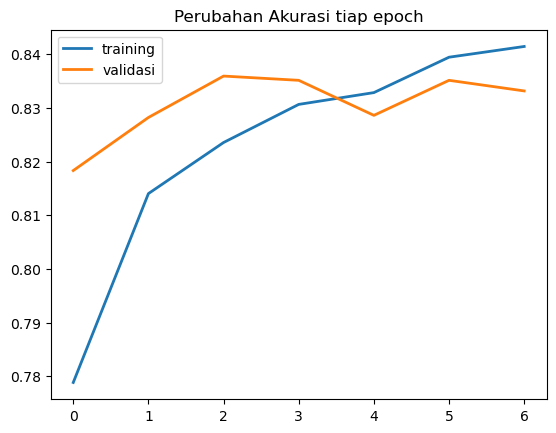

158/158 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step

Classification Report :
              precision    recall  f1-score   support

           0   0.851126  0.807677  0.828832      2527
           1   0.816949  0.858670  0.837290      2526

    accuracy                       0.833168      5053
   macro avg   0.834038  0.833173  0.833061      5053
weighted avg   0.834041  0.833168  0.833060      5053



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ spatial_dropout1d_1             │ (None, 1, 3445)        │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 1, 128)         │     1,829,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 1, 128)         │        82,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,916,097 (7.31 MB)

 Trainable params: 1,916,097 (7.31 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
1421/1421 ━━━━━━━━━━━━━━━━━━━━ 48s 30ms/step - accuracy: 0.7436 - loss: 0.4889 - val_accuracy: 0.8255 - val_loss: 0.3646
Epoch 2/10
1421/1421 ━━━━━━━━━━━━━━━━━━━━ 40s 28ms/step - accuracy: 0.8118 - loss: 0.3756 - val_accuracy: 0.8280 - val_loss: 0.3527
Epoch 3/10
1421/1421 ━━━━━━━━━━━━━━━━━━━━ 42s 29ms/step - accuracy: 0.8217 - loss: 0.3618 - val_accuracy: 0.8260 - val_loss: 0.3540
Epoch 4/10
1421/1421 ━━━━━━━━━━━━━━━━━━━━ 48s 34ms/step - accuracy: 0.8326 - loss: 0.3494 - val_accuracy: 0.8284 - val_loss: 0.3490
Epoch 5/10
1421/1421 ━━━━━━━━━━━━━━━━━━━━ 41s 29ms/step - accuracy: 0.8380 - loss: 0.3409 - val_accuracy: 0.8300 - val_loss: 0.3509
Epoch 6/10
1421/1421 ━━━━━━━━━━━━━━━━━━━━ 40s 28ms/step - accuracy: 0.8353 - loss: 0.3363 - val_accuracy: 0.8272 - val_loss: 0.3524
Epoch 7/10
1421/1421 ━━━━━━━━━━━━━━━━━━━━ 40s 28ms/step - accuracy: 0.8451 - loss: 0.3249 - val_accuracy: 0.8298 - val_loss: 0.3505


158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

Classification Report :
              precision    recall  f1-score   support

           0   0.853328  0.796597  0.823987      2527
           1   0.809206  0.863025  0.835249      2526

    accuracy                       0.829804      5053
   macro avg   0.831267  0.829811  0.829618      5053
weighted avg   0.831271  0.829804  0.829617      5053



Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ spatial_dropout1d_2             │ (None, 1, 3445)        │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 1, 128)         │     1,829,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 1, 128)         │        82,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,916,097 (7.31 MB)

 Trainable params: 1,916,097 (7.31 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
1421/1421 ━━━━━━━━━━━━━━━━━━━━ 45s 28ms/step - accuracy: 0.7443 - loss: 0.4854 - val_accuracy: 0.8225 - val_loss: 0.3667
Epoch 2/10
1421/1421 ━━━━━━━━━━━━━━━━━━━━ 42s 29ms/step - accuracy: 0.8128 - loss: 0.3755 - val_accuracy: 0.8294 - val_loss: 0.3544
Epoch 3/10
1421/1421 ━━━━━━━━━━━━━━━━━━━━ 45s 32ms/step - accuracy: 0.8277 - loss: 0.3556 - val_accuracy: 0.8276 - val_loss: 0.3538
Epoch 4/10
1421/1421 ━━━━━━━━━━━━━━━━━━━━ 40s 28ms/step - accuracy: 0.8303 - loss: 0.3457 - val_accuracy: 0.8253 - val_loss: 0.3512
Epoch 5/10
1421/1421 ━━━━━━━━━━━━━━━━━━━━ 39s 28ms/step - accuracy: 0.8346 - loss: 0.3411 - val_accuracy: 0.8326 - val_loss: 0.3486
Epoch 6/10
1421/1421 ━━━━━━━━━━━━━━━━━━━━ 40s 28ms/step - accuracy: 0.8366 - loss: 0.3362 - val_accuracy: 0.8355 - val_loss: 0.3462
Epoch 7/10
1421/1421 ━━━━━━━━━━━━━━━━━━━━ 38s 27ms/step - accuracy: 0.8398 - loss: 0.3296 - val_accuracy: 0.8294 - val_loss: 0.3494
Epoch 8/10
1421/1421 ━━━━━━━━━━━━━━━━━━━━ 37s 26ms/step - accuracy: 0.8

158/158 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step

Classification Report :
              precision    recall  f1-score   support

           0   0.840891  0.821923  0.831299      2527
           1   0.825784  0.844418  0.834997      2526

    accuracy                       0.833168      5053
   macro avg   0.833337  0.833171  0.833148      5053
weighted avg   0.833339  0.833168  0.833148      5053



In [27]:
result = []
result.append(hybrid_lstm_cnn(x_train, y_train, x_test, y_test))
result.append(hybrid_lstm_cnn(x_train, y_train, x_test, y_test))
result.append(hybrid_lstm_cnn(x_train, y_train, x_test, y_test))

In [31]:
average = np.mean(result, axis=0, dtype=float)
print('Average Accuracy  :', average[0])
print('Average Precision :', average[1])
print('Average Recall    :', average[2])
print('Average F1-Score  :', average[3])

Average Accuracy  : 0.832046968797414
Average Precision : 0.8173129222785295
Average Recall    : 0.8553708102401689
Average F1-Score  : 0.8358454015289624
